In [1]:
import os
os.listdir('superfish_screenshot_dataset_2/superfish_screenshot_dataset/')

['screenshots0000_3180',
 'screenshots0000_3183',
 'screenshots0000_3179',
 'screenshots0000_3184',
 'screenshots0000_3186',
 'screenshots0000_3181',
 'screenshots0000_3185',
 'screenshots0000_3178',
 'screenshots0000_3182']

In [2]:
os.getcwd()

'/BystrovA'

In [37]:
!pip install torchsummary

In [3]:
import torch
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
import random
import torchvision.utils as vutils
import argparse
import math
import cv2
from matplotlib import pyplot as plt

from torchsummary import summary

from abc import abstractmethod

# Root directory for dataset
# dataroot = "fish_screenshots_test/"
dataroot = "superfish_screenshot_dataset_2/superfish_screenshot_dataset/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 256

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

embedding_image_size = 4

# Number of channels in the training images. For color images this is 3
in_channels = 1

# Size of z latent vector
nz = 100

# Number of training epochs
num_epochs = 50 # Original is 5 on a dataset of 1 million

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 3

num_training_updates = 15000

num_hiddens = 64

embedding_dim = 64
num_embeddings = 64

commitment_cost = 0.25
vq_coef = 0

decay = 0.99

learning_rate = 1e-3

num_channels = 1


entropy_weight = 1
kld_weight = 0.00025

In [4]:
# Set random seed for reproducibility
seed = 1141
# seed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", seed)
random.seed(seed)
torch.manual_seed(seed)

Random Seed:  1141


In [5]:
class EdgesDataset(datasets.ImageFolder):
  def __init__(self, root, dim, is_valid_file=None):
    super(EdgesDataset, self).__init__(root=root, is_valid_file=is_valid_file)
    self.dim = dim

  def __getitem__(self, index):
    image_path, target = self.samples[index]
    
    # do your magic here
    img = cv2.imread(image_path)
    img = img[32:-32, 32:-32]
    img = cv2.resize(img, self.dim)
    img = cv2.Canny(img,150,250)
    # you need to convert img from np.array to torch.tensor
    # this has to be done CAREFULLY!
    sample = transforms.ToTensor()(img)
    return sample, target

In [6]:
train_ds = ImageFolder(
    root=dataroot,
#     dim=[image_size,image_size]
    transform = transforms.Compose([transforms.CenterCrop([600-64,800-64]),
                               transforms.Resize([image_size,image_size]),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(num_output_channels=1),
                               transforms.ToTensor(),])
)

dataloader = DataLoader(train_ds, batch_size, shuffle=True)

In [7]:
train_ds = EdgesDataset(
    root=dataroot,
    dim=[image_size,image_size]
#     transform = transforms.Compose([transforms.CenterCrop([600-64,800-64]),
#                                transforms.Resize([image_size,image_size]),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),])
)

dataloader = DataLoader(train_ds, batch_size, shuffle=True)

In [8]:
var = []
i = 0
for batch in dataloader:
    var.append(torch.var(batch[0]))
    i+=1
    if i > 20:
        print('break')
        break

break


In [9]:
# data_variance = 0.03357546404004097

In [10]:
data_variance  = sum(var) / len(var)
data_variance = data_variance.item()
data_variance

0.0812213122844696

In [11]:
true_percent = []
i = 0
for batch in dataloader:
    
    true_percent.append(torch.count_nonzero(batch[0]) / image_size ** 2 / batch_size)
    i+=1
    if i > 20:
        print('break')
        break

break


In [12]:
true_percentage  = sum(true_percent) / len(true_percent)
true_percentage = true_percentage.item()
true_percentage

0.0904579609632492

cuda:8


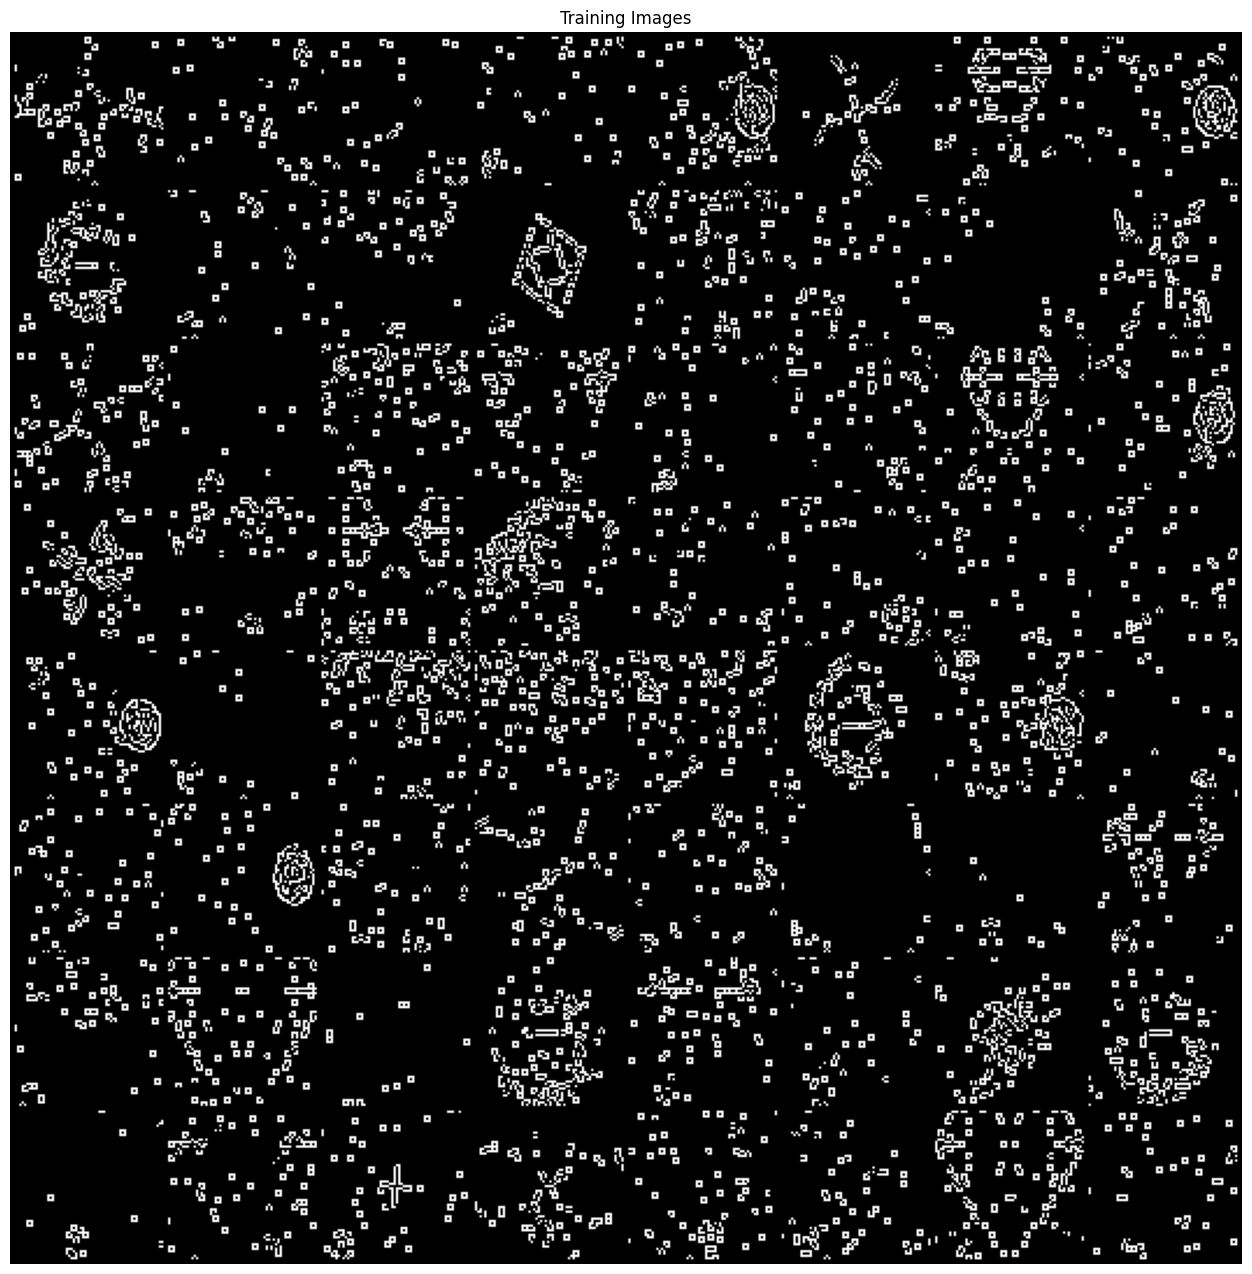

In [13]:
# Decide which device we want to run on
device = torch.device("cuda:8" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)).numpy())


In [14]:
next(iter(dataloader))[0].shape

torch.Size([256, 1, 64, 64])

In [15]:
def calc_same_pad(i: int, k: int, s: int, d: int) -> int:
    return max((math.ceil(i / s) - 1) * s + (k - 1) * d + 1 - i, 0)

class Conv2dSame(torch.nn.Conv2d):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
#         print(x.size())
        ih, iw = x.size()[-2:]

        pad_h = calc_same_pad(i=ih, k=self.kernel_size[0], s=self.stride[0], d=self.dilation[0])
        pad_w = calc_same_pad(i=iw, k=self.kernel_size[1], s=self.stride[1], d=self.dilation[1])
        
        if pad_h > 0 or pad_w > 0:
            x = F.pad(
                x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2]
            )
            
        x = F.conv2d(
            x,
            self.weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )
        
        return x
    
class ConvTranspose2dSame(torch.nn.ConvTranspose2d):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        ih, iw = x.size()[-2:]
        ih *= 2
        iw *= 2

        pad_h = calc_same_pad(i=ih, k=self.kernel_size[0], s=self.stride[0], d=self.dilation[0])
        pad_w = calc_same_pad(i=iw, k=self.kernel_size[1], s=self.stride[1], d=self.dilation[1])
        
        x = F.conv_transpose2d(
            x,
            self.weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )
        
        if pad_h > 0 or pad_w > 0:
            x = F.pad(
                x, list(map(lambda x: -x * self.stride[0], [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2]))
            )
            
        return x

In [16]:
def power_calc(number, base):
    power = 0
    
    if (number < 1):
        raise ValueError(f'not power of {base}')
        
    while (number != 1):
            if (number % base != 0):
                raise ValueError(f'not power of {base}')
            number = number // base
            power += 1
             
    return power

In [17]:
power_calc(128,2)

7

In [18]:
list(reversed(np.arange(1,4)))

[3, 2, 1]

In [19]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, embedding_dim, image_size, embedding_image_size):
        super(Encoder, self).__init__()
        
        num_of_convs = power_calc(image_size,2) - power_calc(embedding_image_size,2)
        
        conv_layers = [Conv2dSame(in_channels=in_channels,
                                 out_channels=num_hiddens // 2**(num_of_convs - 1),
                                 kernel_size=3,
                                 stride=2), 
                       nn.BatchNorm2d(num_hiddens // 2**(num_of_convs - 1)),
                       nn.LeakyReLU()]
        
        for i in reversed(range(1, num_of_convs)):
            conv_layers.append(Conv2dSame(in_channels=num_hiddens//2**(i),
                                 out_channels=num_hiddens//2**(i-1),
                                 kernel_size=3,
                                 stride=2))
            conv_layers.append(nn.BatchNorm2d(num_hiddens//2**(i-1)))
            conv_layers.append(nn.LeakyReLU())

        self._convs = nn.Sequential(*conv_layers)
        
        if num_hiddens != embedding_dim:
            self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                          out_channels=embedding_dim,
                                          kernel_size=1, 
                                          stride=1)

    def forward(self, x):
        
        x = self._convs(x)
        
        if num_hiddens != embedding_dim:
            x = self._pre_vq_conv(x)
        
        return x

In [20]:
encoder = Encoder(in_channels, num_hiddens, embedding_dim, image_size, embedding_image_size).to(device)

In [418]:
summary(encoder, (in_channels, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1           [-1, 16, 32, 32]             160
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         LeakyReLU-3           [-1, 16, 32, 32]               0
        Conv2dSame-4           [-1, 32, 16, 16]           4,640
       BatchNorm2d-5           [-1, 32, 16, 16]              64
         LeakyReLU-6           [-1, 32, 16, 16]               0
        Conv2dSame-7             [-1, 64, 8, 8]          18,496
       BatchNorm2d-8             [-1, 64, 8, 8]             128
         LeakyReLU-9             [-1, 64, 8, 8]               0
       Conv2dSame-10            [-1, 128, 4, 4]          73,856
      BatchNorm2d-11            [-1, 128, 4, 4]             256
        LeakyReLU-12            [-1, 128, 4, 4]               0
Total params: 97,632
Trainable params: 97,632
Non-trainable params: 0
---------------------------------

In [21]:
class Decoder(nn.Module):
    def __init__(self, out_channels, num_hiddens, embedding_dim,  image_size, embedding_image_size):
        super(Decoder, self).__init__()
        
        if num_hiddens != embedding_dim:
            self.posq_vq_conv = nn.Conv2d(in_channels=embedding_dim,
                                     out_channels=num_hiddens,
                                     kernel_size=1, 
                                     stride=1)
        
        num_of_convs_transes = power_calc(image_size,2) - power_calc(embedding_image_size,2)
        
        conv_trans_layers = [ConvTranspose2dSame(in_channels=num_hiddens,
                                 out_channels=num_hiddens // 2,
                                 kernel_size=3,
                                 stride=2), 
                             nn.BatchNorm2d(num_hiddens // 2),
                             nn.LeakyReLU()]
        
        for i in range(power_calc(embedding_image_size,2), power_calc(image_size,2) - 1):
            
            if i != power_calc(image_size,2) - 2:
                conv_trans_layers.append(ConvTranspose2dSame(in_channels=num_hiddens//2**(i-1-power_calc(embedding_image_size,2)+2),
                                 out_channels=num_hiddens//2**(i-power_calc(embedding_image_size,2)+2),
                                 kernel_size=3,
                                 stride=2))
                conv_trans_layers.append(nn.BatchNorm2d(num_hiddens//2**(i-power_calc(embedding_image_size,2)+2)))
                conv_trans_layers.append(nn.LeakyReLU())
            else:
                conv_trans_layers.append(ConvTranspose2dSame(in_channels=num_hiddens//2**(i-1-power_calc(embedding_image_size,2)+2),
                                 out_channels=out_channels,
                                 kernel_size=3,
                                 stride=2))
                conv_trans_layers.append(nn.Sigmoid())

        self._conv_transes = nn.Sequential(*conv_trans_layers)

    def forward(self, x):
        
        if num_hiddens != embedding_dim:
            x = self.posq_vq_conv(x)
        
        x = self._conv_transes(x)
        
        return x

In [22]:
decoder = Decoder(in_channels, num_hiddens, 
                                embedding_dim,  image_size, embedding_image_size).to(device)

In [421]:
summary(decoder, (embedding_dim, embedding_image_size, embedding_image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
ConvTranspose2dSame-1             [-1, 64, 8, 8]          73,792
       BatchNorm2d-2             [-1, 64, 8, 8]             128
         LeakyReLU-3             [-1, 64, 8, 8]               0
ConvTranspose2dSame-4           [-1, 32, 16, 16]          18,464
       BatchNorm2d-5           [-1, 32, 16, 16]              64
         LeakyReLU-6           [-1, 32, 16, 16]               0
ConvTranspose2dSame-7           [-1, 16, 32, 32]           4,624
       BatchNorm2d-8           [-1, 16, 32, 32]              32
         LeakyReLU-9           [-1, 16, 32, 32]               0
ConvTranspose2dSame-10            [-1, 1, 64, 64]             145
          Sigmoid-11            [-1, 1, 64, 64]               0
Total params: 97,249
Trainable params: 97,249
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forwa

In [23]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, vq_coef):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost
        self._vq_coef = vq_coef

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = self._vq_coef * q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [24]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, vq_coef, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        self._vq_coef = vq_coef
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
#         print(inputs.size())
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        vq_loss = F.mse_loss(quantized, inputs.detach())
#         print(quantized.shape,inputs.shape)
        
        loss = self._vq_coef * vq_loss + self._commitment_cost * e_latent_loss 
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encoding_indices

In [25]:
class EdgeDetectionLoss(nn.Module):
    def __init__(self, w1, w2, w3, data_variance):
        super(EdgeDetectionLoss, self).__init__()
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        self.data_variance = data_variance

    def forward(self, output, target):
        loss = -target*output *self.w1 + target*(1-output) *self.w2 + output*(1-target)*self.w3
        return loss.mean() / data_variance

edge_loss = EdgeDetectionLoss(w1=1, w2=0.01, w3=0.01, data_variance=data_variance*4)

In [26]:
class EdgeDetectionEntropyLoss(nn.Module):
    def __init__(self, true_percentage):
        super(EdgeDetectionEntropyLoss, self).__init__()
        self.true_percentage = true_percentage

    def forward(self, output, target):
        loss = (1 - self.true_percentage) * target * torch.log(output)\
        + self.true_percentage * (1 - target) * torch.log(1 - output)
        return - loss.mean()

edge_loss = EdgeDetectionEntropyLoss(true_percentage)

In [27]:
class VQ_VAE(nn.Module):
    def __init__(self, num_channels, num_hiddens, 
                 num_embeddings, embedding_dim, image_size, embedding_image_size, commitment_cost, vq_coef, decay=0):
        super(VQ_VAE, self).__init__()
        
        self._encoder = Encoder(num_channels, num_hiddens,
                                embedding_dim, image_size, embedding_image_size,)
        
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        
        if decay > 0: 
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, vq_coef, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim, 
                                              commitment_cost, vq_coef)
        
        self._decoder = Decoder(num_channels, num_hiddens, 
                                embedding_dim,  image_size, embedding_image_size)

    def forward(self, x):
        z = self._encoder(x)
        loss, quantized, perplexity, _ = self._vq_vae(z)
#         print(quantized.shape)
        x_recon = self._decoder(quantized)
#         print(x_recon.shape)

        return loss, x_recon, perplexity

In [28]:
entropy_loss = nn.CrossEntropyLoss()

In [29]:
model = VQ_VAE(num_channels, num_hiddens, num_embeddings, embedding_dim, image_size, embedding_image_size, commitment_cost, vq_coef, decay).to(device)

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [31]:
class VanillaVAE(nn.Module):
    def __init__(self, in_channels, num_hiddens, image_size, embedding_image_size,
                 embedding_dim, true_percentage):
        super(VanillaVAE, self).__init__()
        
        self.num_hiddens = num_hiddens
        self.embedding_dim = embedding_dim
            
        self.encoder = Encoder(in_channels, num_hiddens, embedding_dim, image_size, embedding_image_size)
        self.decoder = Decoder(in_channels, num_hiddens, embedding_dim,  image_size, embedding_image_size)
        self.fc_mu = nn.Linear(num_hiddens*embedding_image_size**2, embedding_dim)
        self.fc_var = nn.Linear(num_hiddens*embedding_image_size**2, embedding_dim)
        
        self.decoder_input = nn.Linear(embedding_dim, num_hiddens*embedding_image_size**2)
        
        self.loss = EdgeDetectionEntropyLoss(true_percentage)
        
    def encode(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        
        return [mu, log_var]
    
    def decode(self, z):
        z = self.decoder_input(z)
        z = z.view(-1, num_hiddens, embedding_image_size, embedding_image_size)
        z = self.decoder(z)
        return z
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    
    def forward(self, x, **kwargs):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), x, mu, log_var]
    
    @abstractmethod
    def loss_f(self, *args, **kwargs):
        output = args[0]
        target = args[1]
        mu = args[2]
        log_var = args[3]
        
        entropy_weight = kwargs['ENTROPY_W']
        
        kld_weight = kwargs['M_N']
        
        recons_loss = self.loss(output, target)
        
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1), dim = 0)
        
        loss = entropy_weight * recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss': recons_loss.detach(), 'KLD': -kld_loss.detach()}
    
    def sample (self, num_samples, current_device):
        z = torch.randn(num_samples, self.latent_dim)
        z = z.to(current_device)
        samples = self.decode(z)    
        return samples
    
    def generate(self, x, **kwargs):
        return self.forward(x)[0]

In [35]:
device = torch.device('cuda:8' if torch.cuda.is_available() else 'cpu')
model = VanillaVAE(in_channels, num_hiddens, image_size, embedding_image_size,
                 embedding_dim, true_percentage).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [34]:
summary(model, (in_channels, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1            [-1, 8, 32, 32]              80
       BatchNorm2d-2            [-1, 8, 32, 32]              16
         LeakyReLU-3            [-1, 8, 32, 32]               0
        Conv2dSame-4           [-1, 16, 16, 16]           1,168
       BatchNorm2d-5           [-1, 16, 16, 16]              32
         LeakyReLU-6           [-1, 16, 16, 16]               0
        Conv2dSame-7             [-1, 32, 8, 8]           4,640
       BatchNorm2d-8             [-1, 32, 8, 8]              64
         LeakyReLU-9             [-1, 32, 8, 8]               0
       Conv2dSame-10             [-1, 64, 4, 4]          18,496
      BatchNorm2d-11             [-1, 64, 4, 4]             128
        LeakyReLU-12             [-1, 64, 4, 4]               0
          Encoder-13             [-1, 64, 4, 4]               0
           Linear-14                   

In [36]:
model.train()
train_res_recon_error = []
train_res_vq_loss = []
train_res_perplexity = []

count = 0
train_res_KLD = []

In [44]:
### Обучение для VAE
with torch.autograd.detect_anomaly():
    for i in np.arange(40000):
        (data, _) = next(iter(dataloader))
        data = data.to(device)
        optimizer.zero_grad()

        data_recon, x, mu, log_var = model(data)
    #     print(data_recon.shape, data.shape)
        model_loss = model.loss_f(data_recon, data, mu, log_var, ENTROPY_W=entropy_weight, M_N=kld_weight)
        loss = model_loss['loss']
        recon_error = model_loss['Reconstruction_Loss']
        KLD = model_loss['KLD']

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        
        optimizer.step()

        train_res_recon_error.append(recon_error.item())
        train_res_KLD.append(KLD.item())

        if (count+1) % 25 == 0:
            print('%d iterations' % (count+1))
            print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
            print('KLD: %.3f' % np.mean(train_res_KLD[-100:]))
            print()
            
        if (count+1) % 1000 == 0:
            torch.save(model.state_dict(), f'VQ_VAE_models/VAE{count}_im{image_size}x{image_size}_emb{embedding_image_size}x{embedding_image_size}-{embedding_dim}-{num_embeddings}_hid{num_hiddens}_edge.pt')

        count += 1



/tmp/ipykernel_68/1201528825.py:2: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


1050 iterations
recon_error: 0.073
KLD: -52.127

1075 iterations
recon_error: 0.072
KLD: -52.298

1100 iterations
recon_error: 0.072
KLD: -52.321

1125 iterations
recon_error: 0.072
KLD: -52.539

1150 iterations
recon_error: 0.072
KLD: -52.652

1175 iterations
recon_error: 0.072
KLD: -52.764

1200 iterations
recon_error: 0.072
KLD: -52.824

1225 iterations
recon_error: 0.072
KLD: -52.826

1250 iterations
recon_error: 0.072
KLD: -53.000

1275 iterations
recon_error: 0.071
KLD: -52.974

1300 iterations
recon_error: 0.071
KLD: -53.159

1325 iterations
recon_error: 0.072
KLD: -53.371

1350 iterations
recon_error: 0.071
KLD: -53.384

1375 iterations
recon_error: 0.071
KLD: -53.578

1400 iterations
recon_error: 0.071
KLD: -53.706

1425 iterations
recon_error: 0.071
KLD: -53.770

1450 iterations
recon_error: 0.071
KLD: -53.835

1475 iterations
recon_error: 0.071
KLD: -53.943

1500 iterations
recon_error: 0.071
KLD: -54.003

1525 iterations
recon_error: 0.071
KLD: -54.062

1550 iterations
reco

KeyboardInterrupt: 

In [224]:
### Обучение для VQ-VAE
for i in np.arange(15000):
    (data, _) = next(iter(dataloader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
#     print(data_recon.shape)
    recon_error = edge_loss(data_recon, data) * 10
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()
    
    train_res_recon_error.append(recon_error.item())
    train_res_vq_loss.append(vq_loss.item())
    train_res_perplexity.append(perplexity.item())

    if (count+1) % 25 == 0:
        print('%d iterations' % (count+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('vq_loss: %.3f' % np.mean(train_res_vq_loss[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()
        
    count += 1



25 iterations
recon_error: 0.314
vq_loss: 0.018
perplexity: 28.446

50 iterations
recon_error: 0.313
vq_loss: 0.018
perplexity: 28.696

75 iterations
recon_error: 0.313
vq_loss: 0.018
perplexity: 28.974

100 iterations
recon_error: 0.313
vq_loss: 0.019
perplexity: 29.343

125 iterations
recon_error: 0.313
vq_loss: 0.019
perplexity: 29.504

150 iterations
recon_error: 0.312
vq_loss: 0.019
perplexity: 29.644

175 iterations
recon_error: 0.312
vq_loss: 0.019
perplexity: 29.815

200 iterations
recon_error: 0.311
vq_loss: 0.019
perplexity: 29.940

225 iterations
recon_error: 0.310
vq_loss: 0.018
perplexity: 30.165

250 iterations
recon_error: 0.310
vq_loss: 0.018
perplexity: 30.397

275 iterations
recon_error: 0.310
vq_loss: 0.018
perplexity: 30.610

300 iterations
recon_error: 0.310
vq_loss: 0.018
perplexity: 30.796

325 iterations
recon_error: 0.310
vq_loss: 0.018
perplexity: 30.946

350 iterations
recon_error: 0.309
vq_loss: 0.018
perplexity: 31.039

375 iterations
recon_error: 0.309
vq_

2975 iterations
recon_error: 0.301
vq_loss: 0.028
perplexity: 32.756

3000 iterations
recon_error: 0.300
vq_loss: 0.028
perplexity: 32.718

3025 iterations
recon_error: 0.300
vq_loss: 0.028
perplexity: 32.713

3050 iterations
recon_error: 0.301
vq_loss: 0.029
perplexity: 32.757

3075 iterations
recon_error: 0.301
vq_loss: 0.029
perplexity: 32.818

3100 iterations
recon_error: 0.301
vq_loss: 0.029
perplexity: 32.899

3125 iterations
recon_error: 0.301
vq_loss: 0.029
perplexity: 32.906

3150 iterations
recon_error: 0.301
vq_loss: 0.029
perplexity: 32.935

3175 iterations
recon_error: 0.302
vq_loss: 0.029
perplexity: 32.978

3200 iterations
recon_error: 0.302
vq_loss: 0.029
perplexity: 32.928

3225 iterations
recon_error: 0.302
vq_loss: 0.029
perplexity: 32.961

3250 iterations
recon_error: 0.302
vq_loss: 0.029
perplexity: 32.991

3275 iterations
recon_error: 0.301
vq_loss: 0.029
perplexity: 32.931

3300 iterations
recon_error: 0.301
vq_loss: 0.029
perplexity: 32.967

3325 iterations
reco

5925 iterations
recon_error: 0.300
vq_loss: 0.032
perplexity: 33.273

5950 iterations
recon_error: 0.300
vq_loss: 0.032
perplexity: 33.278

5975 iterations
recon_error: 0.299
vq_loss: 0.032
perplexity: 33.269

6000 iterations
recon_error: 0.300
vq_loss: 0.032
perplexity: 33.265

6025 iterations
recon_error: 0.300
vq_loss: 0.033
perplexity: 33.285

6050 iterations
recon_error: 0.300
vq_loss: 0.033
perplexity: 33.281

6075 iterations
recon_error: 0.300
vq_loss: 0.033
perplexity: 33.279

6100 iterations
recon_error: 0.300
vq_loss: 0.032
perplexity: 33.273

6125 iterations
recon_error: 0.300
vq_loss: 0.033
perplexity: 33.315

6150 iterations
recon_error: 0.300
vq_loss: 0.033
perplexity: 33.304

6175 iterations
recon_error: 0.301
vq_loss: 0.033
perplexity: 33.319

6200 iterations
recon_error: 0.301
vq_loss: 0.033
perplexity: 33.335

6225 iterations
recon_error: 0.300
vq_loss: 0.033
perplexity: 33.330

6250 iterations
recon_error: 0.300
vq_loss: 0.033
perplexity: 33.322

6275 iterations
reco

8875 iterations
recon_error: 0.300
vq_loss: 0.035
perplexity: 33.380

8900 iterations
recon_error: 0.300
vq_loss: 0.035
perplexity: 33.381

8925 iterations
recon_error: 0.300
vq_loss: 0.035
perplexity: 33.268

8950 iterations
recon_error: 0.300
vq_loss: 0.035
perplexity: 33.271

8975 iterations
recon_error: 0.300
vq_loss: 0.035
perplexity: 33.295

9000 iterations
recon_error: 0.300
vq_loss: 0.035
perplexity: 33.309

9025 iterations
recon_error: 0.300
vq_loss: 0.035
perplexity: 33.349

9050 iterations
recon_error: 0.299
vq_loss: 0.034
perplexity: 33.287

9075 iterations
recon_error: 0.299
vq_loss: 0.035
perplexity: 33.256

9100 iterations
recon_error: 0.300
vq_loss: 0.035
perplexity: 33.255

9125 iterations
recon_error: 0.300
vq_loss: 0.035
perplexity: 33.298

9150 iterations
recon_error: 0.300
vq_loss: 0.035
perplexity: 33.298

9175 iterations
recon_error: 0.300
vq_loss: 0.035
perplexity: 33.273

9200 iterations
recon_error: 0.299
vq_loss: 0.035
perplexity: 33.236

9225 iterations
reco

11800 iterations
recon_error: 0.299
vq_loss: 0.037
perplexity: 33.374

11825 iterations
recon_error: 0.299
vq_loss: 0.037
perplexity: 33.343

11850 iterations
recon_error: 0.299
vq_loss: 0.037
perplexity: 33.402

11875 iterations
recon_error: 0.299
vq_loss: 0.037
perplexity: 33.430

11900 iterations
recon_error: 0.299
vq_loss: 0.037
perplexity: 33.457

11925 iterations
recon_error: 0.299
vq_loss: 0.037
perplexity: 33.476

11950 iterations
recon_error: 0.300
vq_loss: 0.037
perplexity: 33.465

11975 iterations
recon_error: 0.299
vq_loss: 0.037
perplexity: 33.447

12000 iterations
recon_error: 0.300
vq_loss: 0.037
perplexity: 33.486

12025 iterations
recon_error: 0.299
vq_loss: 0.037
perplexity: 33.430

12050 iterations
recon_error: 0.299
vq_loss: 0.037
perplexity: 33.430

12075 iterations
recon_error: 0.299
vq_loss: 0.037
perplexity: 33.445

12100 iterations
recon_error: 0.299
vq_loss: 0.037
perplexity: 33.395

12125 iterations
recon_error: 0.300
vq_loss: 0.037
perplexity: 33.464

12150 

14700 iterations
recon_error: 0.299
vq_loss: 0.040
perplexity: 33.386

14725 iterations
recon_error: 0.299
vq_loss: 0.040
perplexity: 33.488

14750 iterations
recon_error: 0.299
vq_loss: 0.040
perplexity: 33.450

14775 iterations
recon_error: 0.299
vq_loss: 0.040
perplexity: 33.486

14800 iterations
recon_error: 0.300
vq_loss: 0.040
perplexity: 33.474

14825 iterations
recon_error: 0.300
vq_loss: 0.040
perplexity: 33.457

14850 iterations
recon_error: 0.299
vq_loss: 0.040
perplexity: 33.417

14875 iterations
recon_error: 0.299
vq_loss: 0.040
perplexity: 33.375

14900 iterations
recon_error: 0.299
vq_loss: 0.040
perplexity: 33.361

14925 iterations
recon_error: 0.299
vq_loss: 0.040
perplexity: 33.326

14950 iterations
recon_error: 0.298
vq_loss: 0.041
perplexity: 33.299

14975 iterations
recon_error: 0.299
vq_loss: 0.041
perplexity: 33.339

15000 iterations
recon_error: 0.298
vq_loss: 0.041
perplexity: 33.351

15025 iterations
recon_error: 0.299
vq_loss: 0.041
perplexity: 33.325

15050 

17600 iterations
recon_error: 0.300
vq_loss: 0.043
perplexity: 33.505

17625 iterations
recon_error: 0.300
vq_loss: 0.043
perplexity: 33.514

17650 iterations
recon_error: 0.300
vq_loss: 0.043
perplexity: 33.493

17675 iterations
recon_error: 0.300
vq_loss: 0.043
perplexity: 33.447

17700 iterations
recon_error: 0.300
vq_loss: 0.043
perplexity: 33.442

17725 iterations
recon_error: 0.300
vq_loss: 0.043
perplexity: 33.437

17750 iterations
recon_error: 0.300
vq_loss: 0.043
perplexity: 33.417

17775 iterations
recon_error: 0.299
vq_loss: 0.043
perplexity: 33.398

17800 iterations
recon_error: 0.299
vq_loss: 0.043
perplexity: 33.398

17825 iterations
recon_error: 0.299
vq_loss: 0.043
perplexity: 33.384

17850 iterations
recon_error: 0.299
vq_loss: 0.043
perplexity: 33.359

17875 iterations
recon_error: 0.299
vq_loss: 0.043
perplexity: 33.343

17900 iterations
recon_error: 0.299
vq_loss: 0.043
perplexity: 33.308

17925 iterations
recon_error: 0.298
vq_loss: 0.043
perplexity: 33.272

17950 

20500 iterations
recon_error: 0.299
vq_loss: 0.045
perplexity: 33.519

20525 iterations
recon_error: 0.299
vq_loss: 0.044
perplexity: 33.523

20550 iterations
recon_error: 0.299
vq_loss: 0.044
perplexity: 33.508

20575 iterations
recon_error: 0.299
vq_loss: 0.045
perplexity: 33.509

20600 iterations
recon_error: 0.299
vq_loss: 0.044
perplexity: 33.507

20625 iterations
recon_error: 0.299
vq_loss: 0.044
perplexity: 33.455

20650 iterations
recon_error: 0.299
vq_loss: 0.045
perplexity: 33.493

20675 iterations
recon_error: 0.300
vq_loss: 0.045
perplexity: 33.568

20700 iterations
recon_error: 0.300
vq_loss: 0.045
perplexity: 33.622

20725 iterations
recon_error: 0.300
vq_loss: 0.045
perplexity: 33.662

20750 iterations
recon_error: 0.300
vq_loss: 0.045
perplexity: 33.578

20775 iterations
recon_error: 0.300
vq_loss: 0.045
perplexity: 33.589

20800 iterations
recon_error: 0.299
vq_loss: 0.045
perplexity: 33.519

20825 iterations
recon_error: 0.299
vq_loss: 0.045
perplexity: 33.526

20850 

23400 iterations
recon_error: 0.300
vq_loss: 0.047
perplexity: 33.727

23425 iterations
recon_error: 0.300
vq_loss: 0.047
perplexity: 33.696

23450 iterations
recon_error: 0.300
vq_loss: 0.047
perplexity: 33.750

23475 iterations
recon_error: 0.300
vq_loss: 0.047
perplexity: 33.674

23500 iterations
recon_error: 0.299
vq_loss: 0.047
perplexity: 33.671

23525 iterations
recon_error: 0.299
vq_loss: 0.047
perplexity: 33.688

23550 iterations
recon_error: 0.298
vq_loss: 0.047
perplexity: 33.599

23575 iterations
recon_error: 0.298
vq_loss: 0.047
perplexity: 33.578

23600 iterations
recon_error: 0.299
vq_loss: 0.047
perplexity: 33.588

23625 iterations
recon_error: 0.299
vq_loss: 0.047
perplexity: 33.596

23650 iterations
recon_error: 0.300
vq_loss: 0.047
perplexity: 33.699

23675 iterations
recon_error: 0.300
vq_loss: 0.047
perplexity: 33.763

23700 iterations
recon_error: 0.299
vq_loss: 0.047
perplexity: 33.791

23725 iterations
recon_error: 0.299
vq_loss: 0.047
perplexity: 33.719

23750 

26300 iterations
recon_error: 0.300
vq_loss: 0.049
perplexity: 33.663

26325 iterations
recon_error: 0.300
vq_loss: 0.049
perplexity: 33.705

26350 iterations
recon_error: 0.300
vq_loss: 0.049
perplexity: 33.744

26375 iterations
recon_error: 0.299
vq_loss: 0.048
perplexity: 33.674

26400 iterations
recon_error: 0.298
vq_loss: 0.048
perplexity: 33.629

26425 iterations
recon_error: 0.298
vq_loss: 0.048
perplexity: 33.582

26450 iterations
recon_error: 0.298
vq_loss: 0.048
perplexity: 33.589

26475 iterations
recon_error: 0.298
vq_loss: 0.049
perplexity: 33.632

26500 iterations
recon_error: 0.299
vq_loss: 0.049
perplexity: 33.638

26525 iterations
recon_error: 0.300
vq_loss: 0.049
perplexity: 33.702

26550 iterations
recon_error: 0.300
vq_loss: 0.049
perplexity: 33.720

26575 iterations
recon_error: 0.299
vq_loss: 0.049
perplexity: 33.698

26600 iterations
recon_error: 0.300
vq_loss: 0.049
perplexity: 33.716

26625 iterations
recon_error: 0.299
vq_loss: 0.049
perplexity: 33.670

26650 

29200 iterations
recon_error: 0.298
vq_loss: 0.050
perplexity: 33.585

29225 iterations
recon_error: 0.298
vq_loss: 0.050
perplexity: 33.606

29250 iterations
recon_error: 0.299
vq_loss: 0.050
perplexity: 33.647

29275 iterations
recon_error: 0.299
vq_loss: 0.050
perplexity: 33.604

29300 iterations
recon_error: 0.299
vq_loss: 0.050
perplexity: 33.574

29325 iterations
recon_error: 0.299
vq_loss: 0.050
perplexity: 33.588

29350 iterations
recon_error: 0.299
vq_loss: 0.050
perplexity: 33.573

29375 iterations
recon_error: 0.298
vq_loss: 0.050
perplexity: 33.553

29400 iterations
recon_error: 0.298
vq_loss: 0.050
perplexity: 33.601

29425 iterations
recon_error: 0.298
vq_loss: 0.050
perplexity: 33.610

29450 iterations
recon_error: 0.299
vq_loss: 0.050
perplexity: 33.578

29475 iterations
recon_error: 0.299
vq_loss: 0.050
perplexity: 33.600

29500 iterations
recon_error: 0.298
vq_loss: 0.050
perplexity: 33.530

29525 iterations
recon_error: 0.298
vq_loss: 0.050
perplexity: 33.523

29550 

32100 iterations
recon_error: 0.298
vq_loss: 0.051
perplexity: 33.406

32125 iterations
recon_error: 0.299
vq_loss: 0.051
perplexity: 33.479

32150 iterations
recon_error: 0.299
vq_loss: 0.051
perplexity: 33.467

32175 iterations
recon_error: 0.298
vq_loss: 0.051
perplexity: 33.504

32200 iterations
recon_error: 0.299
vq_loss: 0.052
perplexity: 33.597

32225 iterations
recon_error: 0.299
vq_loss: 0.052
perplexity: 33.608

32250 iterations
recon_error: 0.300
vq_loss: 0.052
perplexity: 33.635

32275 iterations
recon_error: 0.299
vq_loss: 0.052
perplexity: 33.654

32300 iterations
recon_error: 0.299
vq_loss: 0.051
perplexity: 33.624

32325 iterations
recon_error: 0.299
vq_loss: 0.051
perplexity: 33.634

32350 iterations
recon_error: 0.299
vq_loss: 0.051
perplexity: 33.624

32375 iterations
recon_error: 0.299
vq_loss: 0.051
perplexity: 33.607

32400 iterations
recon_error: 0.299
vq_loss: 0.051
perplexity: 33.623

32425 iterations
recon_error: 0.299
vq_loss: 0.052
perplexity: 33.617

32450 

35000 iterations
recon_error: 0.298
vq_loss: 0.053
perplexity: 33.594

35025 iterations
recon_error: 0.300
vq_loss: 0.053
perplexity: 33.717

35050 iterations
recon_error: 0.300
vq_loss: 0.053
perplexity: 33.722

35075 iterations
recon_error: 0.299
vq_loss: 0.053
perplexity: 33.688

35100 iterations
recon_error: 0.300
vq_loss: 0.053
perplexity: 33.760

35125 iterations
recon_error: 0.299
vq_loss: 0.053
perplexity: 33.633

35150 iterations
recon_error: 0.299
vq_loss: 0.053
perplexity: 33.662

35175 iterations
recon_error: 0.300
vq_loss: 0.053
perplexity: 33.726

35200 iterations
recon_error: 0.300
vq_loss: 0.053
perplexity: 33.712

35225 iterations
recon_error: 0.300
vq_loss: 0.053
perplexity: 33.728

35250 iterations
recon_error: 0.300
vq_loss: 0.053
perplexity: 33.697

35275 iterations
recon_error: 0.300
vq_loss: 0.053
perplexity: 33.691

35300 iterations
recon_error: 0.299
vq_loss: 0.053
perplexity: 33.703

35325 iterations
recon_error: 0.299
vq_loss: 0.053
perplexity: 33.687

35350 

37900 iterations
recon_error: 0.298
vq_loss: 0.053
perplexity: 33.597

37925 iterations
recon_error: 0.298
vq_loss: 0.053
perplexity: 33.595

37950 iterations
recon_error: 0.298
vq_loss: 0.053
perplexity: 33.566

37975 iterations
recon_error: 0.298
vq_loss: 0.053
perplexity: 33.566

38000 iterations
recon_error: 0.297
vq_loss: 0.053
perplexity: 33.580

38025 iterations
recon_error: 0.297
vq_loss: 0.053
perplexity: 33.572

38050 iterations
recon_error: 0.297
vq_loss: 0.053
perplexity: 33.581

38075 iterations
recon_error: 0.297
vq_loss: 0.053
perplexity: 33.584

38100 iterations
recon_error: 0.298
vq_loss: 0.053
perplexity: 33.570

38125 iterations
recon_error: 0.298
vq_loss: 0.053
perplexity: 33.632

38150 iterations
recon_error: 0.299
vq_loss: 0.053
perplexity: 33.745

38175 iterations
recon_error: 0.299
vq_loss: 0.053
perplexity: 33.748

38200 iterations
recon_error: 0.299
vq_loss: 0.053
perplexity: 33.725

38225 iterations
recon_error: 0.298
vq_loss: 0.053
perplexity: 33.724

38250 

In [45]:
torch.save(model.state_dict(), f'VQ_VAE_models/VAE{count}_im{image_size}x{image_size}_emb{embedding_image_size}x{embedding_image_size}-{embedding_dim}-{num_embeddings}_hid{num_hiddens}_edge.pt')

In [68]:
from scipy.signal import savgol_filter

In [69]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_vq_loss_smooth = savgol_filter(train_res_vq_loss, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

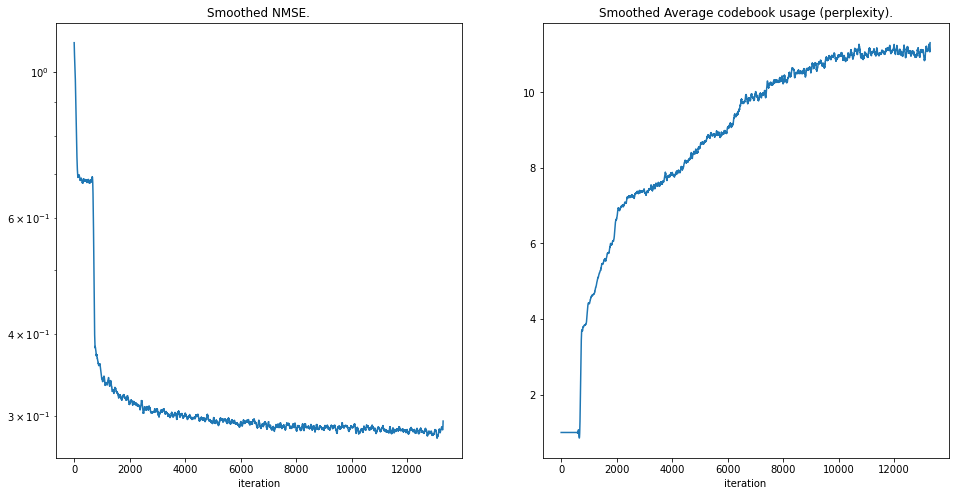

In [315]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,3,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,3,2)
ax.plot(train_res_vq_loss_smooth)
ax.set_title('Smoothed vq_loss.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,3,3)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [37]:
os.chdir('C:/Users/user/')

In [39]:
import cv2 

ValueError: num must be an integer with 1 <= num <= 32, not 33

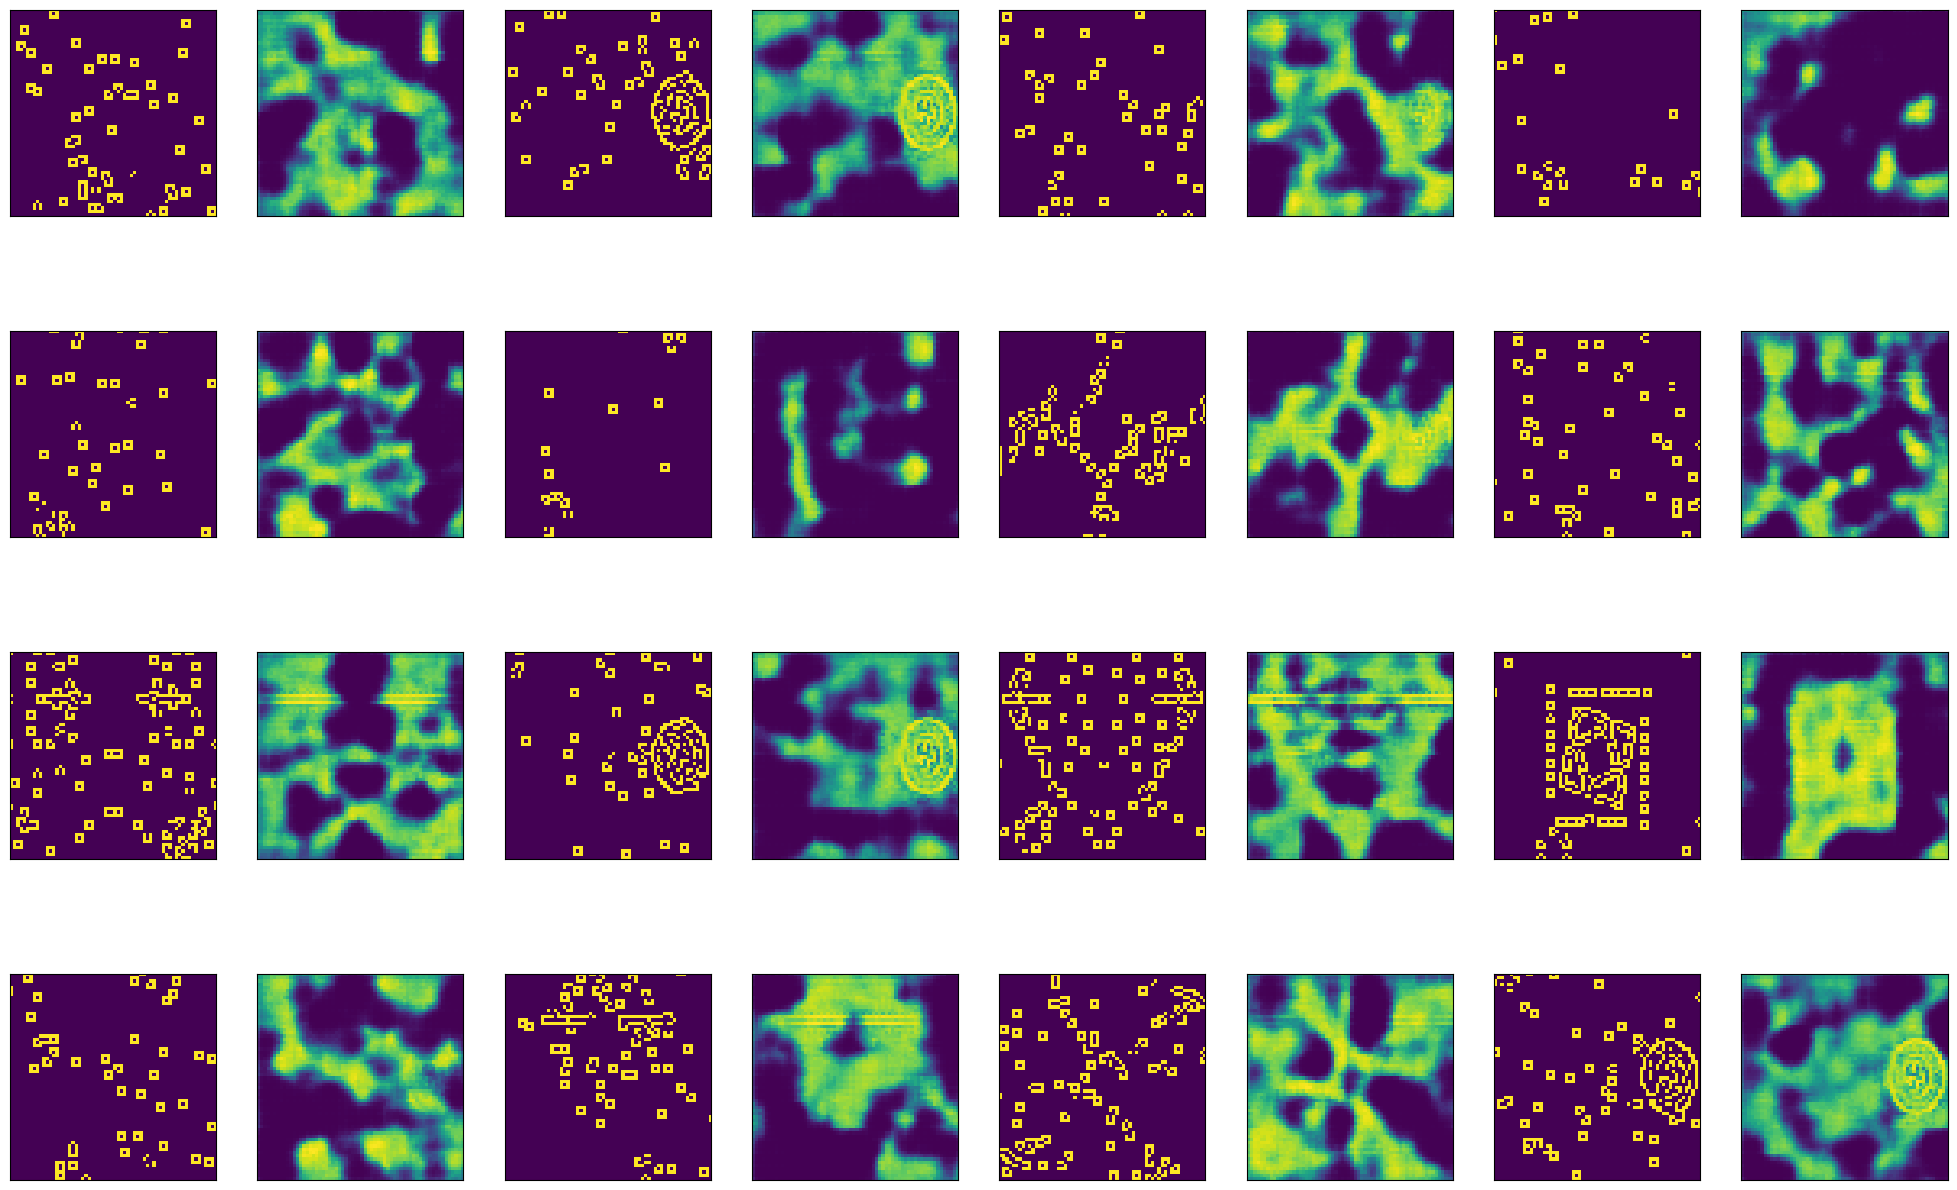

In [46]:
iter_dl = iter(dataloader)
x = next(iter_dl)
x = x[0]
# _, data_recon, _ = model(x.to(device))
data_recon, _, _, _ = model(x.to(device))

fig = plt.figure(figsize=(25, 16))
for i in np.arange(0,32):
    
    ax = fig.add_subplot(4, 8, i*2 + 1, xticks=[], yticks=[])
    img = x[i].numpy().transpose(1,2,0)
    plt.imshow(img)
    
    ax = fig.add_subplot(4, 8, i*2 + 2, xticks=[], yticks=[])
    img = (data_recon[i].cpu().detach().numpy().transpose(1,2,0))
    plt.imshow(img)
    

In [41]:
for param in model.parameters():
    print(param.data.max())

tensor(0.3474, device='cuda:8')
tensor(0.3317, device='cuda:8')
tensor(1.0592, device='cuda:8')
tensor(0.4619, device='cuda:8')
tensor(0.2587, device='cuda:8')
tensor(0.0797, device='cuda:8')
tensor(1.3790, device='cuda:8')
tensor(0.4831, device='cuda:8')
tensor(0.3574, device='cuda:8')
tensor(0.0820, device='cuda:8')
tensor(1.1704, device='cuda:8')
tensor(0.3878, device='cuda:8')
tensor(0.2796, device='cuda:8')
tensor(0.0581, device='cuda:8')
tensor(0.9346, device='cuda:8')
tensor(0.1032, device='cuda:8')
tensor(0.2619, device='cuda:8')
tensor(0.0545, device='cuda:8')
tensor(1.1699, device='cuda:8')
tensor(0.2280, device='cuda:8')
tensor(0.2630, device='cuda:8')
tensor(0.0773, device='cuda:8')
tensor(1.0610, device='cuda:8')
tensor(0.3242, device='cuda:8')
tensor(0.2401, device='cuda:8')
tensor(0.0085, device='cuda:8')
tensor(1.5176, device='cuda:8')
tensor(0.5660, device='cuda:8')
tensor(0.4707, device='cuda:8')
tensor(-0.3682, device='cuda:8')
tensor(0.2043, device='cuda:8')
tensor(

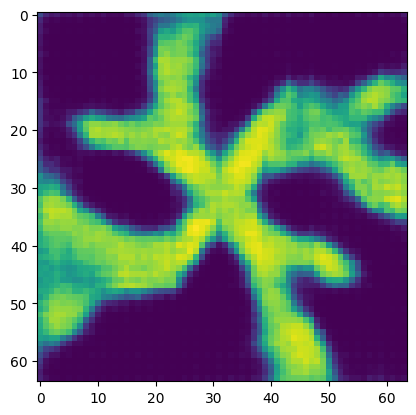

In [43]:
# _, data_recon, _ = model(x.to(device))
data_recon, _, _, _ = model(x.to(device))
img = (data_recon[7].cpu().detach().numpy().transpose(1,2,0))
plt.imshow(img)
# print(img)